In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

# Install TensorFlow Addons
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Lambda

print("TensorFlow Version:", tf.__version__)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version: 2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = "/content/drive/MyDrive/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = base_dir

In [4]:
WORK_DIR = '/content/drive/MyDrive/Alzheimer_s Dataset/'

# Define class labels
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']


In [5]:
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
# Define parameters for image augmentation
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

# Image Data Generator for data augmentation
work_dr = IDG(rescale=1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
              data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)


In [7]:
train_data_gen = work_dr.flow_from_directory(directory=work_dir, target_size=DIM, batch_size=32, shuffle=False)



Found 6400 images belonging to 4 classes.


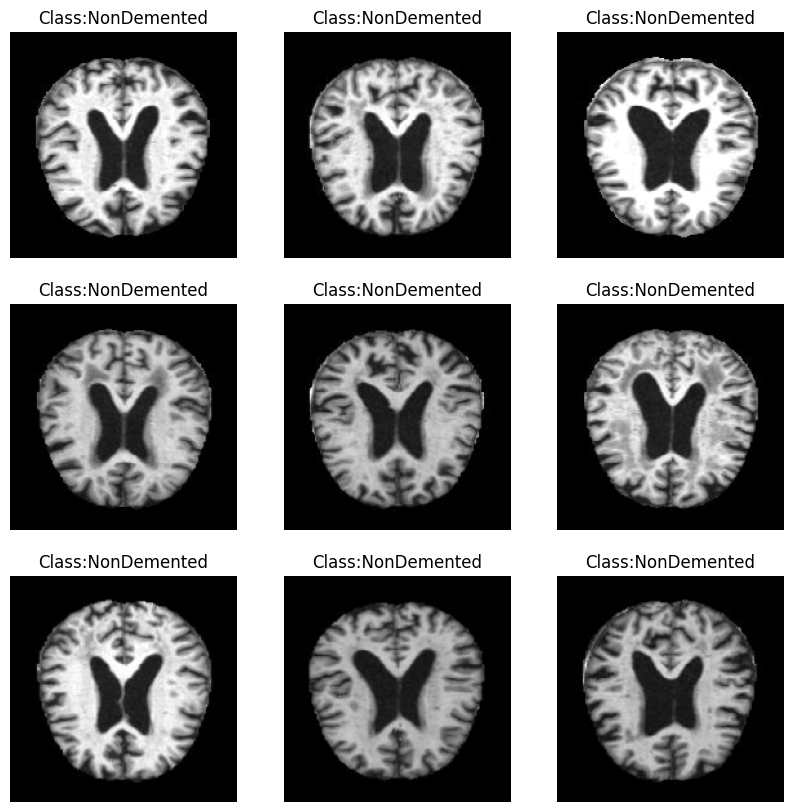

In [8]:
def show_images(generator, y_pred=None):
    """
    Function to display a grid of 9 images with labels.
    """
    # Dictionary to map labels
    labels = dict(zip([0, 1, 2, 3], CLASSES))

    # Get a batch of images and labels
    x, y = generator.next()

    # Display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = i % 32  # Ensure index is within bounds of the batch size
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))


# Display sample images
show_images(train_data_gen)


In [9]:
# Load train and validation data
train = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=.2, subset='training',
                                                             seed=1337, image_size=IMAGE_SIZE, batch_size=64)
validation = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=.2, subset='validation',
                                                                  seed=1337, image_size=IMAGE_SIZE, batch_size=64)


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [10]:
# Define class names
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
num_classes = len(class_names)
train.class_names = class_names
validation.class_names = class_names

In [11]:
# Function to convert labels to one-hot encoding
from tensorflow.data.experimental import AUTOTUNE

def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# Apply one-hot encoding to train and validation data
train = train.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validation = validation.map(one_hot_label, num_parallel_calls=AUTOTUNE)

# Cache and prefetch train and validation data
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

# Define exponential decay function for learning rate
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)


In [12]:
# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Model checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Define convolutional block

In [13]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

# Define dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [14]:
# Function to build the CNN model with CAM
def build_model_with_cam():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),  # Input layer

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),  # Convolutional layers
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),  # Convolutional blocks
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),  # Dropout layer

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        GlobalAveragePooling2D(),  # Global Average Pooling

        dense_block(512, 0.7),  # Dense blocks
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(num_classes, use_bias=False),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # Normalize activations
    ])
    return model


In [15]:
# Build the model with CAM
model = build_model_with_cam()

# Metrics
METRICS = [tf.keras.metrics.AUC(name='auc')]


In [16]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics=METRICS
)

In [17]:
# Train the model
history = model.fit(
    train,
    validation_data=validation,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler, reduce_lr],
    epochs=2  # Increase number of epochs for training
)

Epoch 1/2
65/65 [==============================] - ETA: 0s - loss: 1.1966 - auc: 0.6999

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 562s 8s/step - loss: 1.1966 - auc: 0.6999 - val_loss: 1.3586 - val_auc: 0.5835 - lr: 0.0100
Epoch 2/2
65/65 [==============================] - 504s 8s/step - loss: 1.1009 - auc: 0.7866 - val_loss: 1.3159 - val_auc: 0.6615 - lr: 0.0089


In [18]:
# Train the model
history = model.fit(
    train,
    validation_data=validation,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler, reduce_lr],
    epochs=2  # Increase number of epochs for training
)

Epoch 1/2
65/65 [==============================] - 500s 8s/step - loss: 1.0918 - auc: 0.7934 - val_loss: 1.1446 - val_auc: 0.7559 - lr: 0.0100
Epoch 2/2
65/65 [==============================] - 502s 8s/step - loss: 1.0883 - auc: 0.7959 - val_loss: 1.2686 - val_auc: 0.6316 - lr: 0.0089


In [20]:
max_val_acc_epoch = np.argmax(history.history['val_auc']) + 1
max_val_acc = max(history.history['val_auc'])

In [21]:
print("Model Accuracy:", max_val_acc)


Model Accuracy: 0.7558655142784119


In [22]:
model.load_weights("alzheimer_model.h5")

In [28]:
# Evaluate the model on the validation set
val_loss, val_auc = model.evaluate(validation)
print("Validation", val_loss)
print("Validation AUC", val_auc)

16/16 [==============================] - 29s 2s/step - loss: 1.1446 - auc: 0.7559
Validation 1.144555926322937
Validation AUC 0.7558655142784119


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Download the image from the provided Google Drive link
!gdown --id 1n7qEmZedySVzvFePgJ37JUYP1wAeTiaB --output test_image.jpg


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1n7qEmZedySVzvFePgJ37JUYP1wAeTiaB
To: /content/test_image.jpg
100% 5.20k/5.20k [00:00<00:00, 9.56MB/s]


In [26]:
# Load the image
test_image_path = "test_image.jpg"
test_image = load_img(test_image_path, target_size=(176, 176))
test_image_array = img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)
test_image_array = preprocess_input(test_image_array)


In [27]:
# Make prediction
predictions = model.predict(test_image_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_names[predicted_class_index]

print("Predicted Class Label:", predicted_class_label)

1/1 [==============================] - 0s 373ms/step
Predicted Class Label: VeryMildDementia
